[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv12 Object Detection on a Custom Dataset

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov12-object-detection-model.ipynb)
[![arXiv](https://img.shields.io/badge/arXiv-2502.12524-b31b1b.svg)](https://arxiv.org/abs/2502.12524)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov12-model)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/sunsmarterjie/yolov12)

[YOLOv12](https://github.com/sunsmarterjie/yolov12) is a newly proposed attention-centric variant of the YOLO family that focuses on incorporating efficient attention mechanisms into the backbone while preserving real-time performance. Instead of relying heavily on CNN-based architectures like its predecessors, YOLOv12 introduces a simple yet powerful “area attention” module, which strategically partitions the feature map to reduce the quadratic complexity of full self-attention. It also adopts residual efficient layer aggregation networks (R-ELAN) to enhance feature aggregation and training stability, especially for larger models. These innovations, together with refinements such as scaled residual connections and a reduced MLP ratio, enable YOLOv12 to harness the benefits of attention (e.g., better global context modeling) without sacrificing speed.

![yolov12-area-attention](https://media.roboflow.com/notebooks/examples/yolov12-area-attention.png)

Compared to prior YOLO iterations (e.g., YOLOv10, YOLOv11, and YOLOv8), YOLOv12 achieves higher detection accuracy with competitive or faster inference times across all model scales. Its five sizes—N, S, M, L, and X—range from 2.6M to 59.1M parameters, striking a strong accuracy–speed balance. For instance, the smallest YOLOv12-N surpasses other “nano” models by over 1% mAP with latency around 1.6 ms on a T4 GPU, and the largest YOLOv12-X achieves 55.2% mAP, comfortably outscoring comparable real-time detectors such as RT-DETR and YOLOv11-X . By matching or exceeding state-of-the-art accuracy while remaining fast, YOLOv12 represents a notable step forward for attention-based real-time object detection.

![yolov12-metrics](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov12-metrics.png)

## Environment setup

### Configure your API keys

To fine-tune YOLOv12, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Mon Apr 28 03:45:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [3]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 136.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 122.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 133.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 104.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━

### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

In [4]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

--2025-04-28 03:47:43--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>] 103.57K  --.-KB/s    in 0.001s  

2025-04-28 03:47:44 (79.4 MB/s) - ‘dog.jpeg’ saved [106055/106055]



## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/yolov12/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.


100%|██████████| 51.4M/51.4M [00:01<00:00, 41.0MB/s]


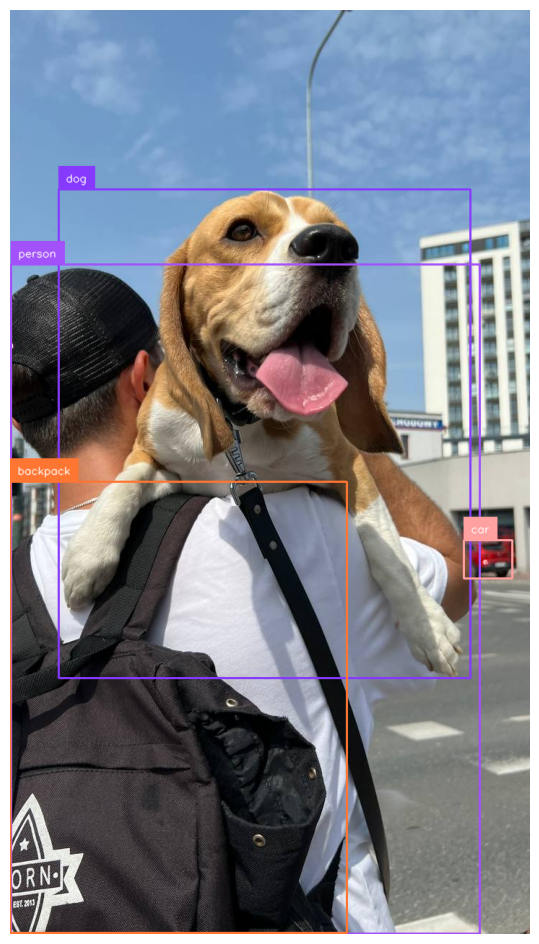

In [5]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = f"{HOME}/dog.jpeg"
image = cv2.imread(image_path)

model = YOLO('yolov12l.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe

In [6]:
from roboflow import download_dataset

from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("").project("")
version = project.version(7)
dataset = version.download("yolov12")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Face_Emotion_Recognition-(fer2025_ml_project_uiu_spring2025)-7 in yolov12:: 100%|██████████| 6364/6364 [00:00<00:00, 9449.42it/s]


In [9]:
!ls "/content/Face_Emotion_Recognition-(fer2025_ml_project_uiu_spring2025)-7"

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [10]:
!sed -i '$d' "/content/Face_Emotion_Recognition-(fer2025_ml_project_uiu_spring2025)-7/data.yaml"
!sed -i '$d' "/content/Face_Emotion_Recognition-(fer2025_ml_project_uiu_spring2025)-7/data.yaml"
!sed -i '$d' "/content/Face_Emotion_Recognition-(fer2025_ml_project_uiu_spring2025)-7/data.yaml"
!sed -i '$d' "/content/Face_Emotion_Recognition-(fer2025_ml_project_uiu_spring2025)-7/data.yaml"
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> "/content/Face_Emotion_Recognition-(fer2025_ml_project_uiu_spring2025)-7/data.yaml"

In [11]:
!cat "/content/Face_Emotion_Recognition-(fer2025_ml_project_uiu_spring2025)-7/data.yaml"

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 12
names: ['angry_female', 'angry_male', 'fear_female', 'fear_male', 'happy_female', 'happy_male', 'sad_female', 'sad_male', 'sleepy_female', 'sleepy_male', 'surprised_female', 'surprised_male']

roboflow:
  workspace: university-f1igv
test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [12]:
from ultralytics import YOLO

model = YOLO('yolov12s.yaml')

results = model.train(data=f'{dataset.location}/data.yaml', epochs=100)

New https://pypi.org/project/ultralytics/8.3.119 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.yaml, data=/content/Face_Emotion_Recognition-(fer2025_ml_project_uiu_spring2025)-7/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=No

100%|██████████| 755k/755k [00:00<00:00, 153MB/s]


Overriding model.yaml nc=80 with nc=12

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1      9344  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2, 1, 2]          
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1     37120  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2, 1, 4]        
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    677120  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytic

100%|██████████| 5.26M/5.26M [00:00<00:00, 270MB/s]


AMP: checks passed ✅


train: Scanning /content/Face_Emotion_Recognition-(fer2025_ml_project_uiu_spring2025)-7/train/labels... 2224 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2224/2224 [00:01<00:00, 1545.08it/s]

train: New cache created: /content/Face_Emotion_Recognition-(fer2025_ml_project_uiu_spring2025)-7/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/Face_Emotion_Recognition-(fer2025_ml_project_uiu_spring2025)-7/valid/labels... 636 images, 0 backgrounds, 0 corrupt: 100%|██████████| 636/636 [00:00<00:00, 1610.89it/s]


val: New cache created: /content/Face_Emotion_Recognition-(fer2025_ml_project_uiu_spring2025)-7/valid/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000625, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      6.75G      3.294      4.854      4.107         45        640: 100%|██████████| 139/139 [01:12<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:08<00:00,  2.39it/s]

                   all        636       1078   0.000927     0.0928   0.000556   0.000103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      6.68G      2.684      4.384       3.36         70        640: 100%|██████████| 139/139 [01:10<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:08<00:00,  2.44it/s]

                   all        636       1078     0.0657      0.118     0.0312    0.00999



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      6.84G      2.169       3.65      2.601         43        640: 100%|██████████| 139/139 [01:09<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.54it/s]

                   all        636       1078      0.101      0.248     0.0688     0.0268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      6.67G      1.932      3.274      2.301         38        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.58it/s]

                   all        636       1078     0.0909      0.205     0.0949     0.0406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      6.67G      1.837      3.053      2.174         46        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.60it/s]

                   all        636       1078     0.0923      0.197     0.0825     0.0306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      6.67G      1.729      2.827      2.043         58        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.60it/s]

                   all        636       1078      0.132      0.348      0.133     0.0697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.84G      1.662      2.686      1.956         50        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.61it/s]

                   all        636       1078      0.134      0.375       0.14     0.0716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      6.84G      1.606      2.622      1.899         53        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.62it/s]

                   all        636       1078      0.151      0.326      0.152     0.0848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      6.67G      1.566      2.537      1.856         40        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.63it/s]

                   all        636       1078      0.145        0.4      0.174     0.0898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      6.69G      1.544      2.504      1.832         39        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.63it/s]

                   all        636       1078      0.146      0.454      0.183      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      6.83G      1.519      2.442      1.808         61        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.62it/s]

                   all        636       1078      0.172      0.466       0.19      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      6.83G      1.475        2.4      1.765         63        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.63it/s]

                   all        636       1078      0.169      0.487      0.186       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      6.67G      1.454      2.351      1.747         58        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.63it/s]

                   all        636       1078      0.186      0.479      0.206      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      6.67G      1.452      2.314      1.733         43        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.63it/s]

                   all        636       1078      0.194      0.519      0.221      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      6.83G      1.421      2.282      1.704         49        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]

                   all        636       1078      0.198      0.524      0.236      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      6.83G      1.406      2.241      1.684         45        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]

                   all        636       1078      0.193      0.522      0.229      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      6.67G      1.407      2.229       1.68         48        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]

                   all        636       1078       0.22      0.552      0.249      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      6.67G      1.367      2.167      1.638         54        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]

                   all        636       1078       0.23      0.506      0.261      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      6.83G      1.353      2.147      1.632         40        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]

                   all        636       1078      0.222      0.544      0.245      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      6.83G      1.366      2.136      1.635         61        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.63it/s]

                   all        636       1078      0.235      0.496      0.278      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      6.67G      1.351      2.115      1.626         50        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]

                   all        636       1078      0.249      0.549      0.301      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      6.67G       1.33      2.093      1.604         51        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]

                   all        636       1078      0.274      0.501      0.315       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      6.81G      1.332      2.066      1.599         49        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]

                   all        636       1078      0.276      0.519      0.325      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      6.83G      1.318      2.066      1.583         56        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]

                   all        636       1078      0.247      0.549      0.331      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      6.67G      1.313       2.04      1.578         48        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]

                   all        636       1078      0.268      0.541      0.311      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      6.67G      1.308      2.019      1.576         48        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]

                   all        636       1078      0.302      0.521      0.342      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      6.83G      1.289      1.988      1.551         42        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]

                   all        636       1078      0.288      0.604      0.358      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      6.83G      1.284      1.992      1.551         62        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]

                   all        636       1078      0.288      0.528      0.335      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      6.67G      1.272      1.969      1.547         54        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]

                   all        636       1078      0.273      0.559      0.339      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      6.67G      1.266      1.944      1.539         49        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]

                   all        636       1078      0.318      0.536      0.378      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      6.83G      1.248      1.922      1.522         55        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.62it/s]

                   all        636       1078       0.33      0.531      0.379      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      6.83G      1.259      1.915      1.526         52        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.66it/s]

                   all        636       1078      0.337      0.581       0.39      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      6.67G      1.277      1.909      1.538         69        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]

                   all        636       1078      0.311      0.563       0.39      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      6.69G      1.258      1.895       1.52         56        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]

                   all        636       1078      0.354      0.546      0.394      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      6.81G      1.253      1.884      1.519         56        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]

                   all        636       1078      0.327      0.568      0.391      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      6.83G      1.242      1.856      1.509         42        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]

                   all        636       1078      0.337       0.57      0.398      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      6.67G      1.226       1.84      1.494         47        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]

                   all        636       1078      0.364      0.561      0.427      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      6.67G       1.23      1.839      1.497         52        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]

                   all        636       1078       0.37      0.569      0.435      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      6.81G      1.211      1.814      1.488         52        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]

                   all        636       1078      0.367      0.563      0.429      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      6.83G      1.214      1.802      1.483         42        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]

                   all        636       1078      0.378      0.587      0.444      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      6.67G      1.204      1.805      1.473         47        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]

                   all        636       1078      0.385      0.536      0.455      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.67G       1.21      1.798      1.482         48        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]

                   all        636       1078      0.368      0.563      0.436      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      6.81G      1.207       1.79      1.477         43        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]

                   all        636       1078       0.39       0.58      0.469      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      6.83G      1.222      1.781      1.484         62        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]

                   all        636       1078      0.383      0.595      0.463        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      6.69G      1.183      1.752      1.462         44        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]

                   all        636       1078      0.404      0.576      0.476      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      6.67G      1.172      1.727      1.447         49        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]

                   all        636       1078      0.393      0.572      0.461      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      6.83G      1.198      1.763      1.464         44        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]

                   all        636       1078        0.4      0.586      0.478      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      6.83G      1.184      1.721      1.454         47        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]

                   all        636       1078       0.42      0.531       0.48      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      6.67G      1.199      1.758      1.466         58        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]

                   all        636       1078      0.406      0.554      0.473      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      6.69G      1.167      1.709      1.451         53        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]

                   all        636       1078      0.408      0.576       0.49      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      6.81G      1.173      1.708      1.438         52        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]

                   all        636       1078      0.419      0.564      0.481      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      6.83G      1.169       1.69      1.436         43        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]

                   all        636       1078       0.41      0.558      0.467       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      6.67G      1.165      1.698      1.436         66        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]

                   all        636       1078      0.417      0.559      0.486      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      6.67G      1.165      1.692      1.443         50        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]

                   all        636       1078      0.416      0.579        0.5      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      6.81G      1.161      1.664      1.442         63        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]

                   all        636       1078      0.426       0.57      0.497       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      6.83G      1.158      1.654      1.442         53        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]

                   all        636       1078      0.438      0.613      0.515      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      6.67G      1.159      1.658      1.438         57        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]

                   all        636       1078      0.462      0.544      0.506      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      6.66G      1.152      1.637      1.426         48        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.66it/s]

                   all        636       1078      0.432      0.601       0.51      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      6.82G      1.148      1.659      1.432         43        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]

                   all        636       1078      0.466      0.586      0.527       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      6.83G      1.135      1.611      1.416         57        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]

                   all        636       1078      0.479      0.554      0.524      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      6.67G      1.148       1.64      1.428         57        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]

                   all        636       1078      0.495      0.544      0.541      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      6.66G      1.143      1.633      1.431         51        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]

                   all        636       1078      0.485      0.605      0.554      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      6.83G       1.13      1.606      1.405         48        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]

                   all        636       1078       0.47      0.585      0.538      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      6.83G      1.128      1.602      1.408         49        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]

                   all        636       1078      0.521       0.53      0.544      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      6.66G      1.123      1.591      1.408         39        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]

                   all        636       1078      0.494      0.594      0.547       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      6.66G      1.135      1.594      1.415         48        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]

                   all        636       1078       0.49      0.569      0.552      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      6.82G      1.131      1.582       1.41         57        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]

                   all        636       1078      0.498      0.585      0.545       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      6.83G      1.117      1.574      1.396         54        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.66it/s]

                   all        636       1078       0.52      0.554      0.569      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      6.69G       1.12      1.566        1.4         38        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]

                   all        636       1078      0.491      0.587      0.557      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      6.66G      1.121      1.568      1.397         48        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]

                   all        636       1078      0.497      0.609      0.565      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      6.82G      1.115      1.553      1.398         49        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]

                   all        636       1078      0.485      0.567      0.561      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      6.83G        1.1      1.545       1.39         44        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.66it/s]

                   all        636       1078       0.53      0.527      0.565      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      6.66G      1.096      1.534      1.393         51        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.66it/s]

                   all        636       1078       0.51      0.595      0.584      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      6.66G      1.095      1.523      1.383         54        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]

                   all        636       1078      0.549       0.56      0.592        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      6.82G       1.09      1.502      1.391         58        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]

                   all        636       1078        0.5      0.605      0.577      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      6.83G      1.094      1.528      1.382         61        640: 100%|██████████| 139/139 [01:09<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]

                   all        636       1078      0.494      0.614       0.58      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      6.66G      1.088      1.476      1.367         52        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.66it/s]

                   all        636       1078      0.522      0.571      0.587      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      6.66G      1.088      1.498      1.379         49        640: 100%|██████████| 139/139 [01:09<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]

                   all        636       1078       0.53      0.587       0.59      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      6.86G      1.088      1.487      1.377         47        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]

                   all        636       1078      0.525      0.611      0.589      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      6.83G      1.085      1.476      1.382         63        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]

                   all        636       1078      0.527      0.581      0.603       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      6.66G      1.079      1.482      1.373         64        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.66it/s]

                   all        636       1078      0.546      0.584      0.595      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      6.66G      1.078      1.469      1.364         49        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]

                   all        636       1078      0.516      0.627      0.607      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      6.82G       1.08      1.453      1.374         40        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]

                   all        636       1078       0.55      0.567      0.597      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      6.83G      1.072      1.461      1.366         55        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]

                   all        636       1078      0.556       0.58      0.606      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      6.67G      1.083      1.473      1.378         50        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.66it/s]

                   all        636       1078      0.533      0.592        0.6      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      6.66G      1.067      1.449      1.363         61        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]

                   all        636       1078      0.525      0.624      0.608      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      6.82G      1.063      1.421      1.352         50        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]

                   all        636       1078      0.525      0.617      0.617      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      6.83G      1.062      1.432      1.357         44        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]

                   all        636       1078      0.526      0.628      0.618      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      6.69G      1.065      1.438      1.352         64        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]

                   all        636       1078      0.543      0.626      0.627      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      6.67G      1.061      1.405      1.361         42        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]

                   all        636       1078      0.555      0.607      0.624      0.427


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      6.82G     0.9936      1.146       1.38         22        640: 100%|██████████| 139/139 [01:10<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]

                   all        636       1078      0.562      0.606       0.62      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      6.83G     0.9768      1.096      1.366         24        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]

                   all        636       1078      0.529      0.641      0.623      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      6.67G     0.9591      1.093      1.356         28        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.66it/s]

                   all        636       1078      0.582      0.611      0.631      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      6.67G     0.9624      1.065      1.352         27        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]

                   all        636       1078      0.536      0.637      0.627      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      6.81G      0.965      1.066      1.349         25        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.66it/s]

                   all        636       1078      0.595      0.585      0.628      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      6.83G     0.9545      1.054      1.347         27        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]

                   all        636       1078      0.551      0.629      0.625      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      6.67G     0.9439      1.037      1.343         24        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]

                   all        636       1078      0.584      0.599      0.634      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      6.67G      0.946      1.043      1.347         24        640: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.66it/s]

                   all        636       1078      0.598      0.589      0.639      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      6.82G     0.9455      1.029      1.343         26        640: 100%|██████████| 139/139 [01:09<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.68it/s]

                   all        636       1078      0.609      0.592      0.642      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      6.82G     0.9465      1.031      1.334         32        640: 100%|██████████| 139/139 [01:09<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.67it/s]

                   all        636       1078      0.605      0.602      0.641      0.442



100 epochs completed in 2.175 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 18.7MB
Optimizer stripped from runs/detect/train/weights/best.pt, 18.7MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 376 layers, 9,078,852 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.57it/s]


                   all        636       1078      0.608      0.593      0.642      0.444
          angry_female         58         93      0.564      0.462      0.542      0.381
            angry_male         51         69      0.479       0.58      0.532       0.39
           fear_female         71        107      0.611      0.402      0.541      0.332
             fear_male         69         99      0.459      0.434      0.481      0.328
          happy_female         65         98      0.748      0.684      0.766      0.473
            happy_male         57         90      0.679        0.7      0.736      0.508
            sad_female         62         77      0.558      0.656      0.622      0.452
              sad_male         59         68      0.563      0.603      0.664      0.505
         sleepy_female         64         87      0.799      0.594      0.762      0.524
           sleepy_male         70         96      0.609       0.65      0.691      0.508
      surprised_femal

## Evaluate fine-tuned YOLOv12 model

In [13]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					    train_batch12510.jpg
confusion_matrix_normalized.png			    train_batch12511.jpg
confusion_matrix.png				    train_batch12512.jpg
events.out.tfevents.1745812381.8742c2c4cbef.1300.0  train_batch1.jpg
F1_curve.png					    train_batch2.jpg
labels_correlogram.jpg				    val_batch0_labels.jpg
labels.jpg					    val_batch0_pred.jpg
P_curve.png					    val_batch1_labels.jpg
PR_curve.png					    val_batch1_pred.jpg
R_curve.png					    val_batch2_labels.jpg
results.csv					    val_batch2_pred.jpg
results.png					    weights
train_batch0.jpg


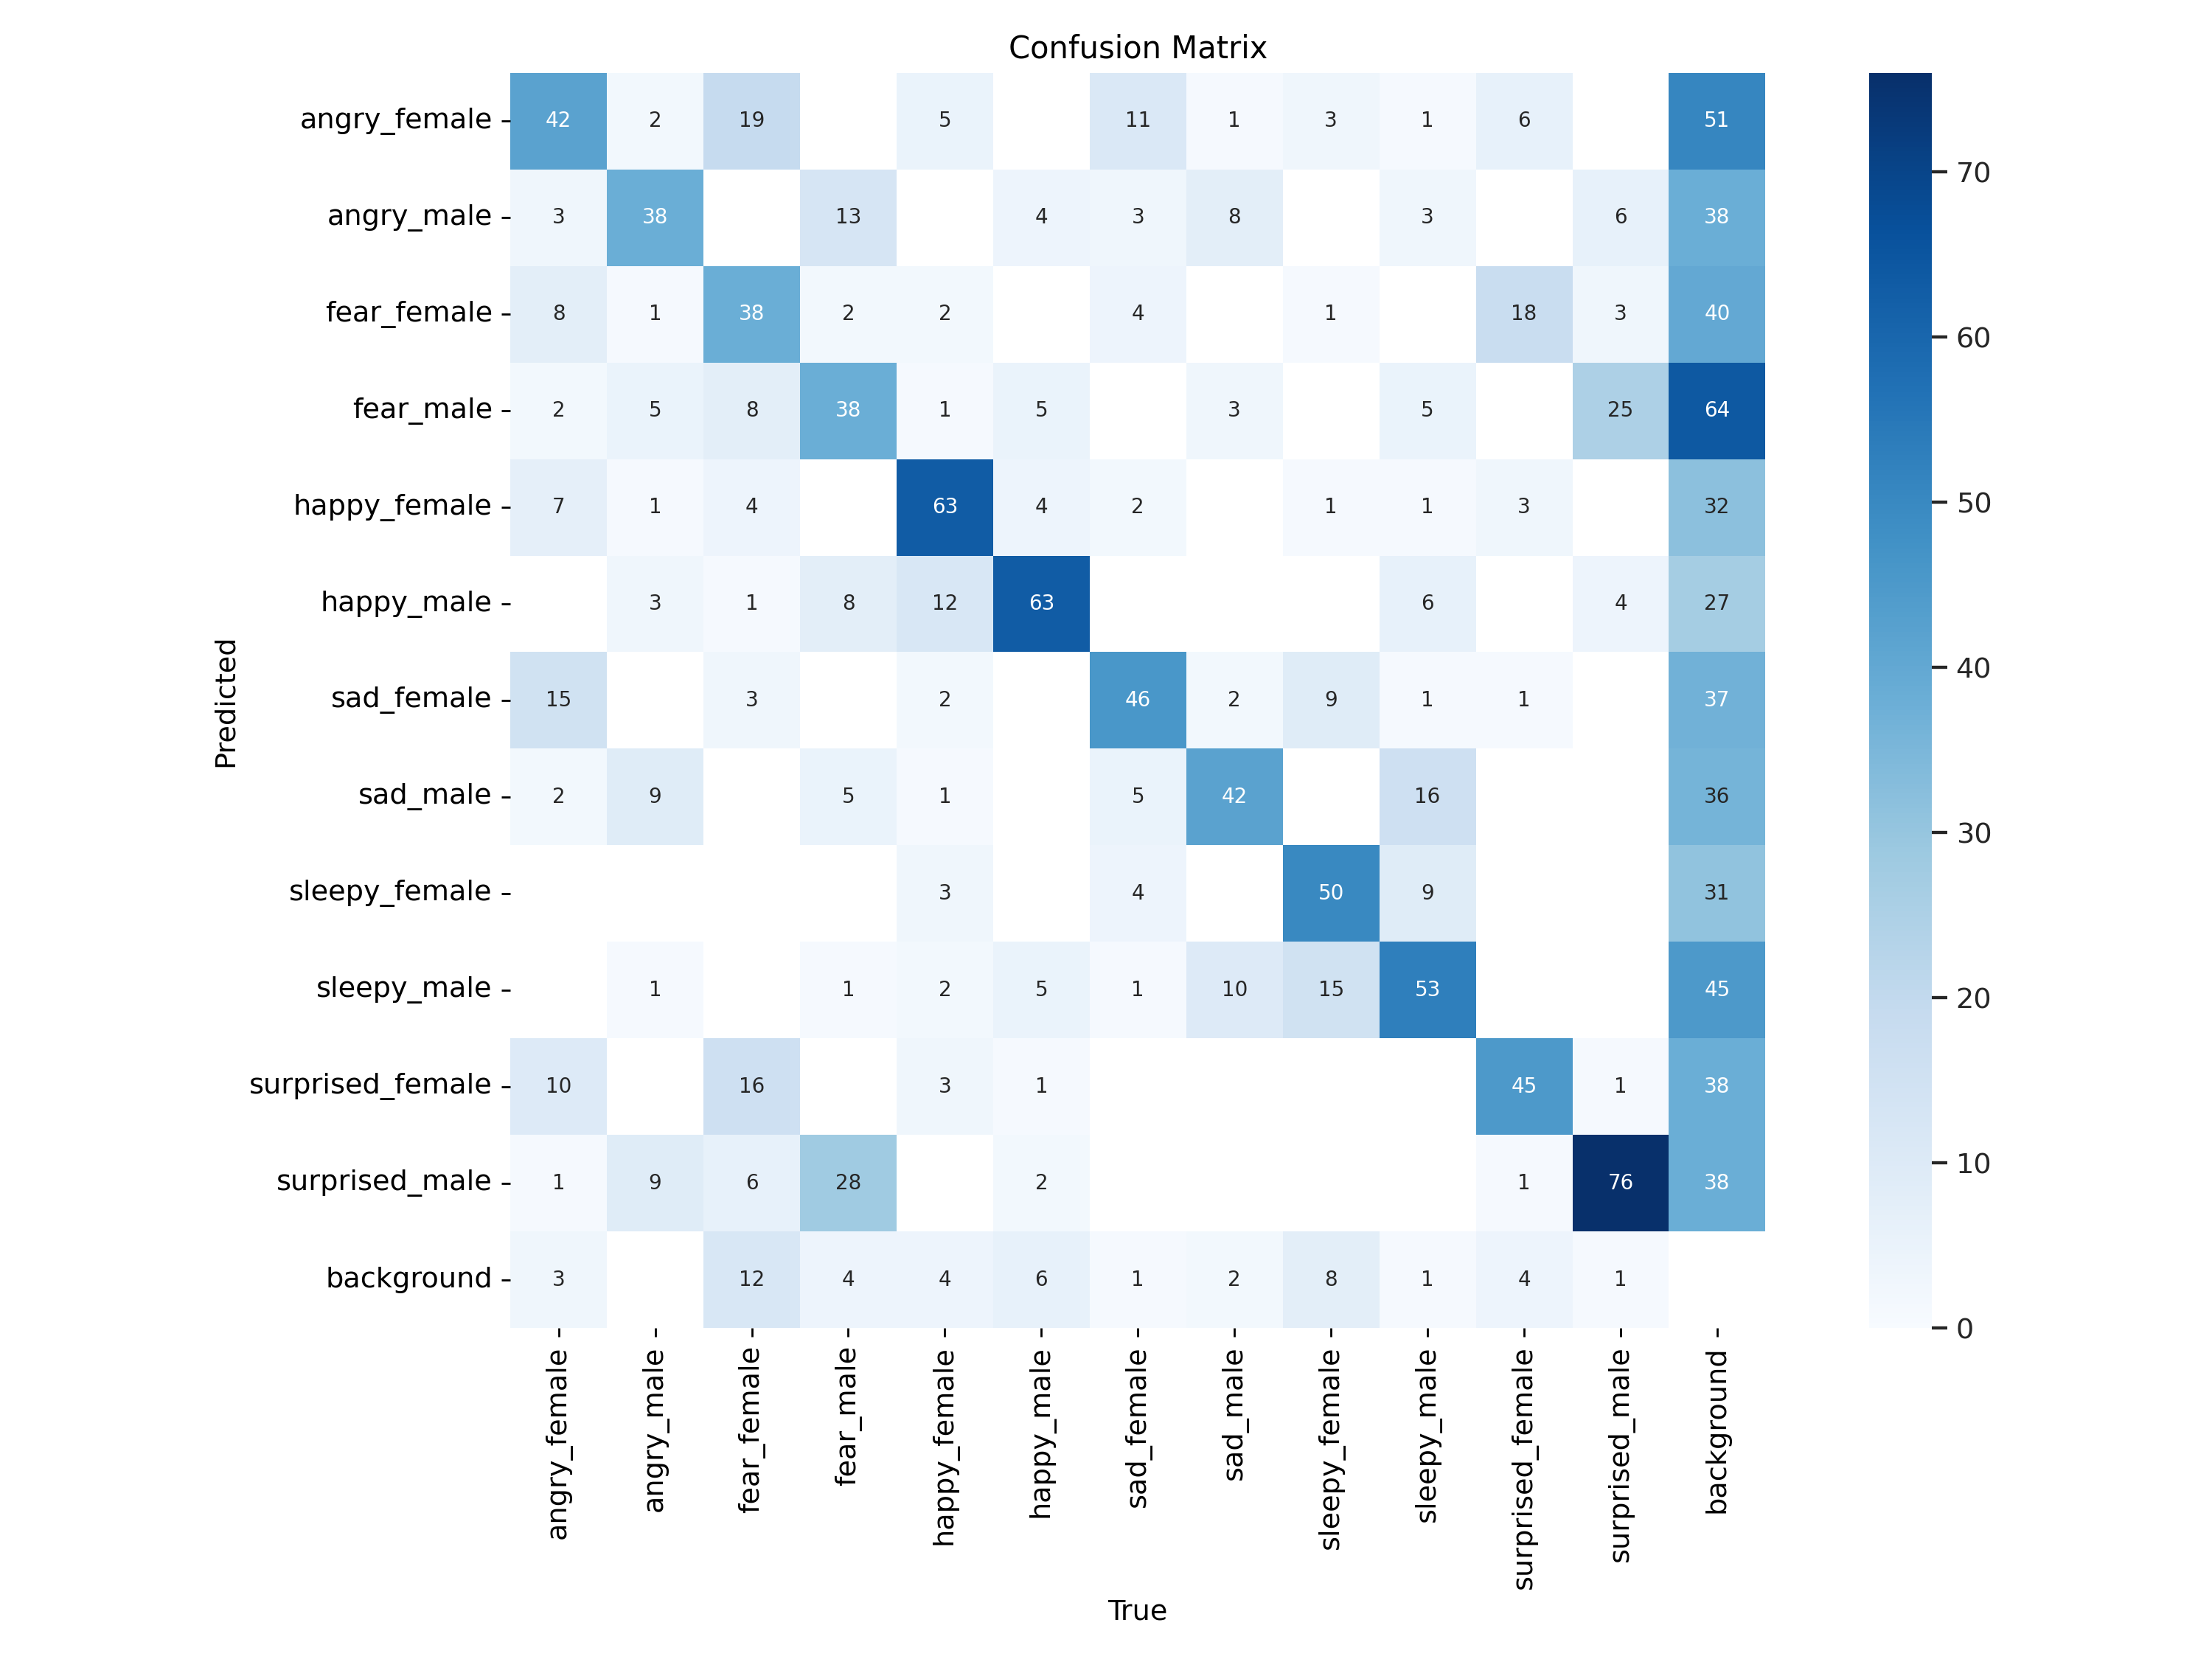

In [14]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=1000)

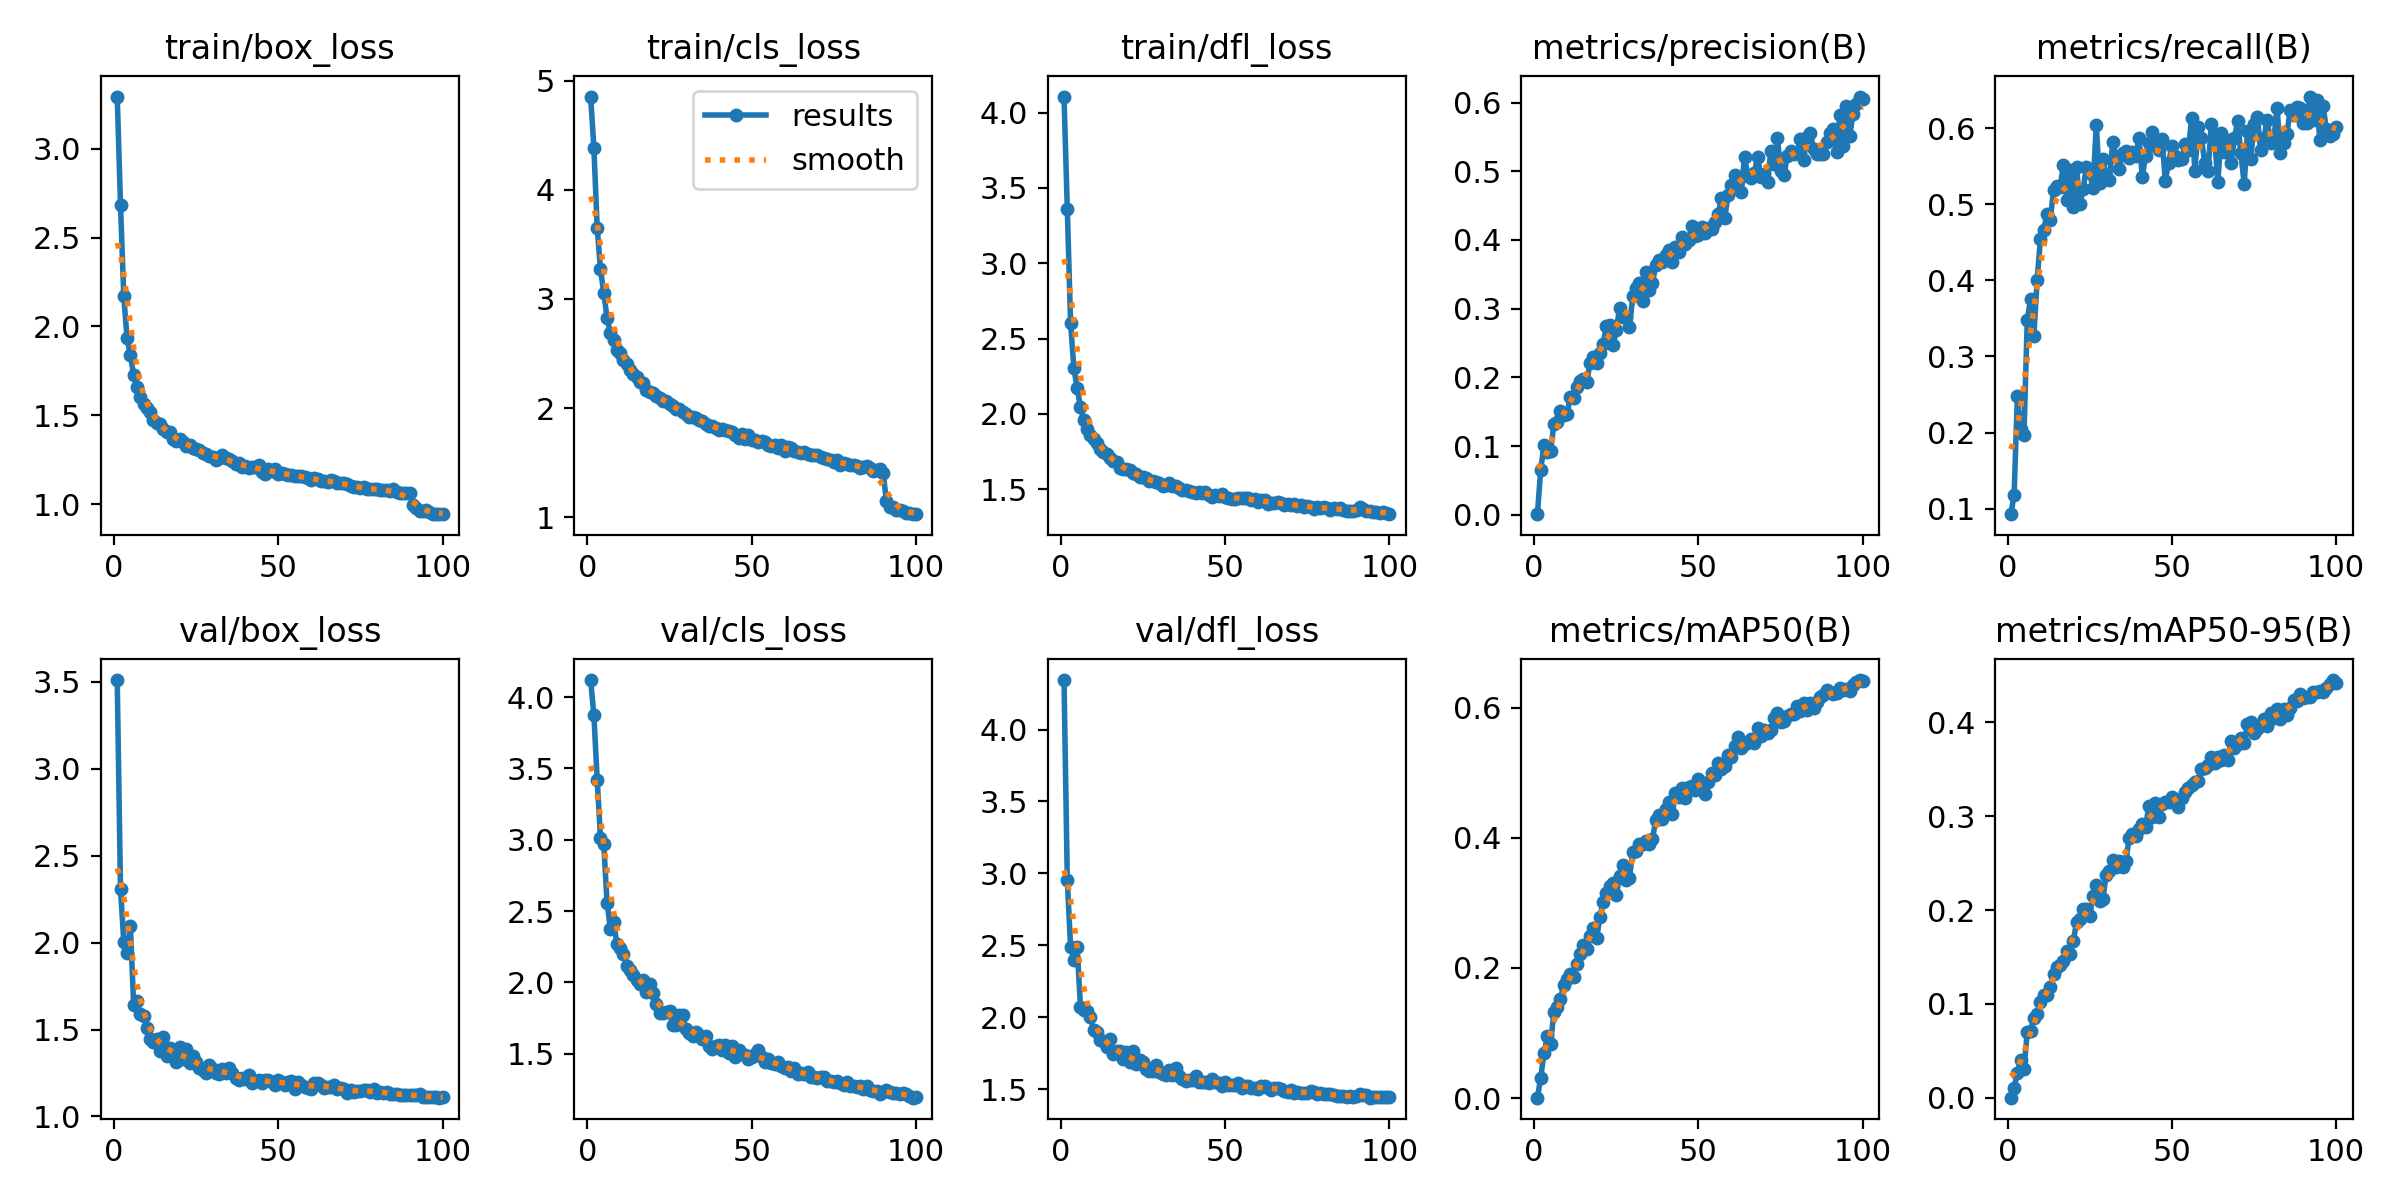

In [15]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

In [16]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"/content/Face_Emotion_Recognition-(fer2025_ml_project_uiu_spring2025)-7/test/images",
    annotations_directory_path=f"/content/Face_Emotion_Recognition-(fer2025_ml_project_uiu_spring2025)-7/test/labels",
    data_yaml_path=f"/content/Face_Emotion_Recognition-(fer2025_ml_project_uiu_spring2025)-7/data.yaml"
)

ds.classes

['angry_female',
 'angry_male',
 'fear_female',
 'fear_male',
 'happy_female',
 'happy_male',
 'sad_female',
 'sad_male',
 'sleepy_female',
 'sleepy_male',
 'surprised_female',
 'surprised_male']

In [17]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [18]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.33367474778885475
mAP 50 0.49496654224953657
mAP 75 0.40469348444821146


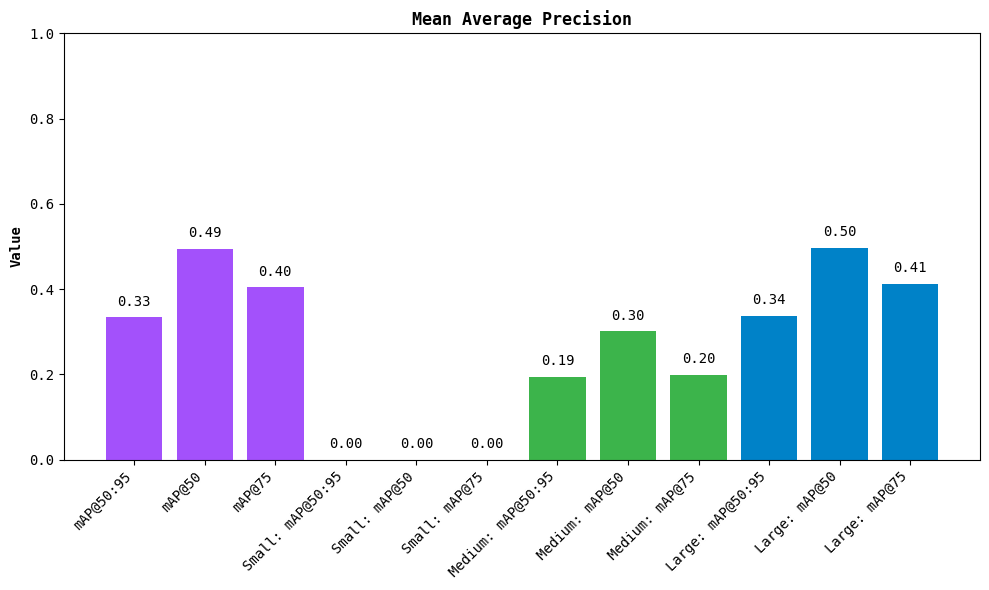

In [19]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [20]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

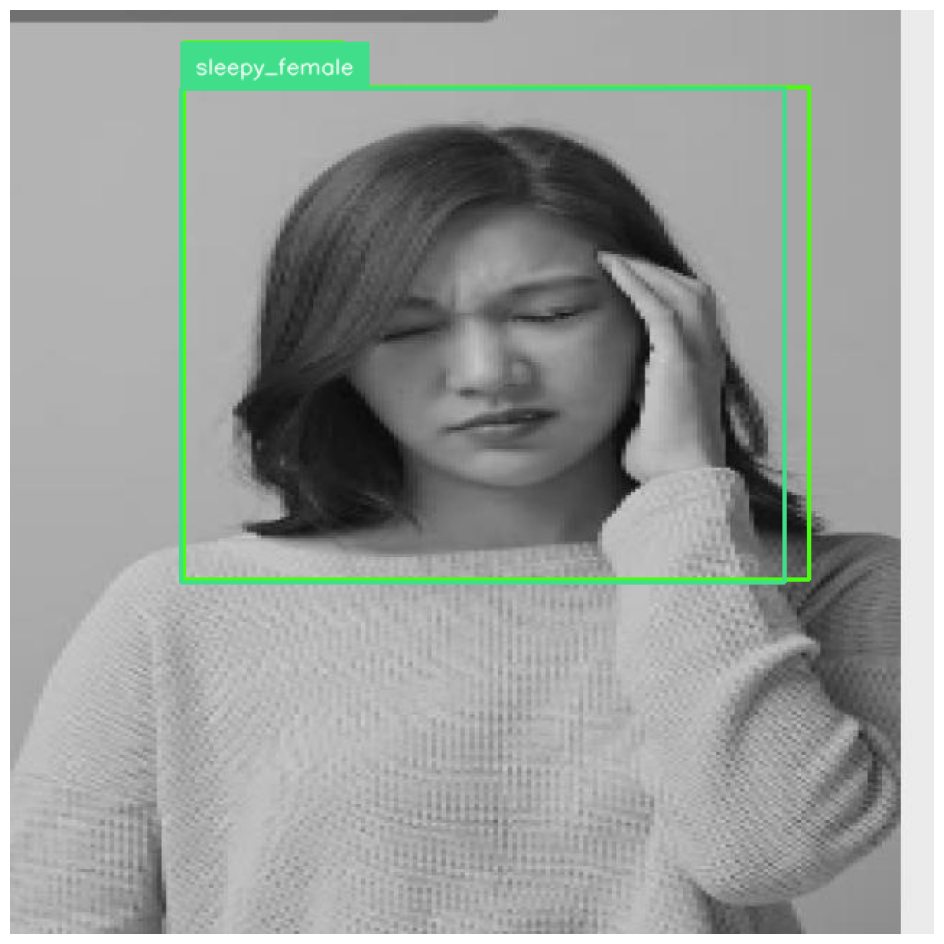

In [21]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

In [22]:
!zip -r /content/folder_name.zip /content/runs/ # Replace 'folder_name' with your desired zip file name
from google.colab import files
files.download('/content/folder_name.zip')

  adding: content/runs/ (stored 0%)
  adding: content/runs/detect/ (stored 0%)
  adding: content/runs/detect/train/ (stored 0%)
  adding: content/runs/detect/train/confusion_matrix_normalized.png (deflated 13%)
  adding: content/runs/detect/train/results.csv (deflated 61%)
  adding: content/runs/detect/train/F1_curve.png (deflated 5%)
  adding: content/runs/detect/train/args.yaml (deflated 52%)
  adding: content/runs/detect/train/weights/ (stored 0%)
  adding: content/runs/detect/train/weights/best.pt (deflated 9%)
  adding: content/runs/detect/train/weights/last.pt (deflated 9%)
  adding: content/runs/detect/train/results.png (deflated 9%)
  adding: content/runs/detect/train/train_batch0.jpg (deflated 7%)
  adding: content/runs/detect/train/train_batch1.jpg (deflated 9%)
  adding: content/runs/detect/train/val_batch1_labels.jpg (deflated 15%)
  adding: content/runs/detect/train/val_batch2_pred.jpg (deflated 14%)
  adding: content/runs/detect/train/labels.jpg (deflated 24%)
  adding: c

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>